# Spark minimal test

## Find Spark and create contexts

In [24]:
import os
import sys #current as of 9/26/2015

import pyspark
from pyspark.sql import SQLContext

# We can give a name to our app (to find it in Spark WebUI) and configure execution mode
# In this case, it is local multicore execution with "local[*]"
app_name = "example-logs"
master = "local[*]"
conf = pyspark.SparkConf().setAppName(app_name).setMaster(master)
sc = pyspark.SparkContext(conf=conf)
sqlContext = SQLContext(sc)


print sc
print sqlContext

In [23]:
# sto shutdown an existing Spart cluster
#sc.stop()

## Implementation plan

In [19]:
# Simple test to cross if Spark is working correctly on Python 2!
rdd = sc.parallelize([1,2,3,3])
rdd.map(lambda x:  x + 1).collect()
#returns [2, 3, 4, 4]

[2, 3, 4, 4]

In [20]:
rdd = sc.parallelize(["#epicfail",  "#hadoop", "#rstats",  "#rstudio", "#rstats", "#spark", "#hadoop", "#hdfs",
"#hadoop",  "#oreilly", "#spark", "#python", "#spark", "#scala", "#spark", "#strataconf", "#strataconf", "#oreilly",
"#spark", "#databricks", "#hadoop", "#hdfs", "#spark",  "#hdfs"], 4)

rdd_distinct = rdd.distinct()
print rdd_distinct.toDebugString().decode("utf8")
for v in rdd_distinct.collect():
    print v

(4) PythonRDD[35] at RDD at PythonRDD.scala:43 []
 |  MapPartitionsRDD[34] at mapPartitions at PythonRDD.scala:374 []
 |  ShuffledRDD[33] at partitionBy at NativeMethodAccessorImpl.java:-2 []
 +-(4) PairwiseRDD[32] at distinct at <ipython-input-20-2a646180af0f>:5 []
    |  PythonRDD[31] at distinct at <ipython-input-20-2a646180af0f>:5 []
    |  ParallelCollectionRDD[30] at parallelize at PythonRDD.scala:423 []
#spark
#epicfail
#scala
#rstudio
#strataconf
#databricks
#python
#hadoop
#hdfs
#oreilly
#rstats


# Data For this Quiz

There is a folder of data here:
https://www.dropbox.com/sh/vfq5el05b6mczf7/AAD4ETesjrflyeknMmX_engJa?dl=0

Notice the HASHSide Join below!

In [13]:
## Note you might get some text in a red box when you run this - It's not an error

## Spark Application - execute with spark-submit

## Imports
import csv
import matplotlib.pyplot as plt

from io import StringIO
from datetime import datetime
from collections import namedtuple
from operator import add, itemgetter
from pyspark import SparkConf, SparkContext

import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline

## Module Constants
APP_NAME = "Flight Delay Analysis"
DATE_FMT = "%Y-%m-%d"
TIME_FMT = "%H%M"

fields   = ('date', 'airline', 'flightnum', 'origin', 'dest', 'dep',
            'dep_delay', 'arv', 'arv_delay', 'airtime', 'distance')
Flight   = namedtuple('Flight', fields)

## Closure Functions
def parse(row):
    """
    Parses a row and returns a named tuple.
    """

    row[0]  = datetime.strptime(row[0], DATE_FMT).date()
    row[5]  = datetime.strptime(row[5], TIME_FMT).time()
    row[6]  = float(row[6])
    row[7]  = datetime.strptime(row[7], TIME_FMT).time()
    row[8]  = float(row[8])
    row[9]  = float(row[9])
    row[10] = float(row[10])
    return Flight(*row[:11])

def split(line):
    """
    Operator function for splitting a line with csv module
    """
    reader = csv.reader(StringIO(line))
    return reader.next() 

def plot(delays):
    """
    Show a bar chart of the total delay per airline
    """
    airlines = [d[0] for d in delays]
    minutes  = [d[1] for d in delays]
    index    = list(range(len(airlines)))

    fig, axe = plt.subplots()
    bars = axe.barh(index, minutes)

    # Add the total minutes to the right
    for idx, air, min in zip(index, airlines, minutes):
        if min > 0:
            bars[idx].set_color('#d9230f')
            axe.annotate(" %0.0f min" % min, xy=(min+1, idx+0.5), va='center')
        else:
            bars[idx].set_color('#469408')
            axe.annotate(" %0.0f min" % min, xy=(10, idx+0.5), va='center')

    # Set the ticks
    ticks = plt.yticks([idx+ 0.5 for idx in index], airlines)
    xt = plt.xticks()[0]
    plt.xticks(xt, [' '] * len(xt))

    #minimize chartjunk
    plt.grid(axis = 'x', color ='white', linestyle='-')

    plt.title('Total Minutes Delayed per Airline')
    plt.show()

## Main functionality
def mainDriver(sc):

    # Load the airlines lookup dictionary
    airlines = dict(sc.textFile("airlines.csv").map(split).collect())

    # Broadcast the lookup dictionary to the cluster
    airline_lookup = sc.broadcast(airlines)

    # Read the CSV Data into an RDD
    flights = sc.textFille("flights.csv").map(split).map(parse)

    # Map the total delay to the airline (joined using the broadcast value)
    delays  = flights.map(lambda f: (airline_lookup.value[f.airline],
                                     add(f.dep_delay, f.arv_delay)))

    # Reduce the total delay for the month to the airline
    delays  = delays.reduceByKey(add).collect()
    delays  = sorted(delays, key=itemgetter(1))

    # Provide output from the driver
    for d in delays:
        print "%0.0f minutes delayed\t%s" % (d[1], d[0])

    # Show a bar chart of the delays
    plot(delays)

#if __name__ == "__main__":
    # Configure Spark
#    conf = SparkConf().setMaster("local[*]")
#    conf = conf.setAppName(APP_NAME)
#    sc   = SparkContext(conf=conf)

    # Execute Main functionality
#    main(sc)

In [17]:
# Load the airlines lookup dictionary
airlines = dict(sc.textFile("airlines.csv").map(split).collect())
airlines

{'19719': 'Coastal Air Transport: CTL',
 '19718': 'Cresent Medivac: CRH',
 '19713': 'Alliance Airlines: ACN',
 '19712': 'Business Express Airlines: BEA',
 '19711': 'Eagle Airline: EGA',
 '19710': 'Armstrong Air Service Inc.: AAP',
 '19717': 'Commuter Airlines (Ca): CMR',
 '19716': 'Barken International: BRK',
 '19715': 'West Penn Commuter: BAT',
 '19714': 'Astor Air: ASR',
 '19399': 'New York Air Inc.: NY',
 '19398': 'Dauphin Island Airways: DAU',
 '19397': 'Republic Airlines Inc.: RC',
 '19396': 'Sky West Aviation Inc.: QG',
 '19395': 'Mid-South Aviation Inc. (1): RCA',
 '19394': 'Mid-South Aviation Inc.: VL',
 '19393': 'Southwest Airlines Co.: WN',
 '19392': 'Rich International Airways: RIQ',
 '19391': 'Pacific Southwest Airlines: PS (1)',
 '19390': 'Air California Inc.: OC',
 '19159': 'Capitol Air Lines: CPA',
 '19158': 'Courtesy Air Service Inc.: COU',
 '19409': 'Bo-S-Aire Airlines Inc.: BOI',
 '19408': 'American Air Transport: AMT',
 '19155': 'Coral Air Inc.: COR',
 '19154': 'Comm

-45442 minutes delayed	Alaska Airlines Inc.: AS
-20654 minutes delayed	Hawaiian Airlines Inc.: HA
39247 minutes delayed	AirTran Airways Corporation: FL
40841 minutes delayed	Virgin America: VX
108480 minutes delayed	Frontier Airlines Inc.: F9
177717 minutes delayed	US Airways Inc.: US
279981 minutes delayed	JetBlue Airways: B6
390614 minutes delayed	United Air Lines Inc.: UA
431755 minutes delayed	American Airlines Inc.: AA
461753 minutes delayed	Delta Air Lines Inc.: DL
493527 minutes delayed	Envoy Air: MQ
519867 minutes delayed	SkyWest Airlines Inc.: OO
1160058 minutes delayed	ExpressJet Airlines Inc.: EV
2181955 minutes delayed	Southwest Airlines Co.: WN


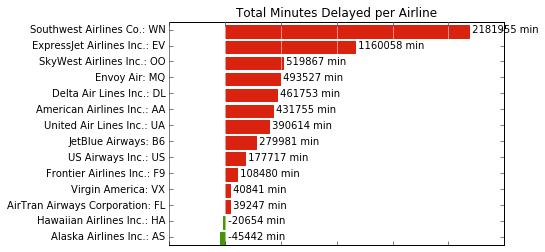

In [18]:
# Broadcast the lookup dictionary to the cluster
airline_lookup = sc.broadcast(airlines)

# Read the CSV Data into an RDD
# transaction fiile
flights = sc.textFile("flights.csv").map(split).map(parse)

# Map the total delay to the airline (joined using the broadcast value)
# Hashside join here!
delays  = flights.map(lambda f: (airline_lookup.value[f.airline],
                                 add(f.dep_delay, f.arv_delay)))

# Reduce the total delay for the month to the airline
delays  = delays.reduceByKey(add).collect()
delays  = sorted(delays, key=itemgetter(1))

# Provide output from the driver
for d in delays:
    print "%0.0f minutes delayed\t%s" % (d[1], d[0])

# Show a bar chart of the delays
plot(delays)


# Quiz: EDA: For soutwest compute the average delay

In [7]:
# For soutwest compute the average delay